# Проект «Ферма»

## Описание проекта <a id='0'></a>

В рамках данного проекта будут созданы две модели машинного обучения для молочного хозяйства «Вольный луг», которое стремиться более эффективно управлять рисками при покупке новых коров.

**Цель**: создать две прогнозные модели МО, которые позволят на основании данных о коровах предсказать а) возможный удой у коровы б) вероятность вкусного молока у коровы.

**План работ**:
- [Описание проекта](#0)
- [Описание данных](#1)
- [Загрузка и изучение данных](#2)
- [Предобработка данных](#3)
- [Исследовательский анализ данных](#4)
- [Корреляционный анализ данных](#5)
- [Обучение модели линейной регрессии](#6)
- [Обучение модели логистической регрессии](#7)
- [Вывод](#8)

## Описание данных <a id='1'></a>

Данные включают в себя 3 таблицы - `ferma_main`, `ferma_dad` и `cow_buy`.

### Таблица `ferma_main` содержит данные о стаде фермера на текущий момент. Информация представлена по следующим стобцам:

**Параметры корма коровы:**
- `ЭКЕ (Энергетическая кормовая единица)` — измерение питательности корма коровы;
- `Сырой протеин — содержание сырого протеина` в корме, в граммах;
- `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.

**Где паслась корова:**
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.

**Особенности коровы:**
- `id` — номер коровы;
- `Порода` — порода коровы;
- `Возраст` — бинарный признак (менее_2_лет, более_2_лет);
- `Имя Папы` — порода папы коровы.

**Характеристики молока:**
- `Жирность` — содержание жиров в молоке, в процентах;
- `Белок` — содержание белков в молоке, в процентах;
- `Вкус молока` — оценка вкуса по личным критериям фермера;
- `Удой` — масса молока, которую корова даёт в год, в килограммах.

### Таблица `ferma_dad` хранит имя папы каждой коровы в стаде фермера.

### Таблица `cow_buy` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой

Структура таблицы почти аналогична таблице `ferma_main`, кроме нескольких особенностей:

- `Белок` и `Жирность` молока указаны на момент покупки — когда «ЭкоФерма» давала им свой корм.
- Параметры кормления `ЭКЕ`, `Сырой протеин`, `СПО` отсутствуют. Недавно технологи заказчика пересмотрели параметры корма и планируют их внедрить после расширения стада. Именно новые параметры нужно использовать, когда вы будете применять предсказательные модели к бурёнкам «ЭкоФермы». По новой схеме фермер планирует увеличить средние значения ЭКЕ, Сырой протеин, СПО на 5%.
- `Удой` и `Вкус` молока неизвестны — их будет необходимо предсказать

## Загрузка и изучение данных <a id='2'></a>

In [1]:
# download package

!pip install --upgrade scikit-learn -q

# import libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import spearmanr
import seaborn as sns
import pandas as pd
import numpy as np
from math import *
import os

In [2]:
# importing data
pth1 = 'ferma_main.csv'
pth2 = 'ferma_dad.csv'
pth3 = 'cow_buy.csv'

def csv_reader(pth):
    if os.path.exists(pth):
        return pd.read_csv(pth, sep=';', decimal=',')
    elif os.path.exists(os.path.join('/datasets', pth)):
        return pd.read_csv(os.path.join('/datasets', pth), sep=';', decimal=',')
    else:
        return 'Something is wrong'
    
ferma_main = csv_reader(pth1)
ferma_dad = csv_reader(pth2)
cow_buy = csv_reader(pth3)

Посмотрим на первые 5 строчек первой таблицы:

In [3]:
ferma_main.head(5)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


Заметим, что названия столбцов не в змеином регистре. Также заметим есть неявные дубликаты в столбце `Тип пастбища`  ('Равнинное' и 'Равнинные' - это одно и то же) и в столбце `dad_breed` ('Айдиал' и  'Айдиалл' - это одно и то же).

Посмотрим на первые 5 строчек второй таблицы:

In [4]:
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


Заметим, что название столбца также не в змеином регистре.

Посмотрим на первые 5 строчек третьей таблицы:

In [5]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%"
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074


Заметим, что название столбцов и в этой таблице не в змеином регистре.

Далее взглянем на основные характеристики таблиц. Для удобства создадим функцию, которая их выводит:

In [6]:
def main_info_about_df(df):
    print(df.info())
    print()
    print('-----------------------------------------')
    print()
    print('Размер таблицы: ', df.shape)
    print()
    print('-----------------------------------------')
    print()
    print('Количество явных дубликатов: ', df.duplicated().sum())
    print()
    print('-----------------------------------------')
    print()
    print('Количество пропусков в каждом столбце таблицы:')
    print(df.isna().sum())

Взглянем на основные характеристики первой таблицы:

In [7]:
main_info_about_df(ferma_main)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

В таблице 634 записи и 12 столбцов. Явных дубликатов 5 => реально у фермера 629 коров. Пропусков в таблице нет.

Взглянем на основные характеристики первой таблицы:

In [8]:
main_info_about_df(ferma_dad)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None

-----------------------------------------

Размер таблицы:  (629, 2)

-----------------------------------------

Количество явных дубликатов:  0

-----------------------------------------

Количество пропусков в каждом столбце таблицы:
id          0
Имя Папы    0
dtype: int64


В таблице 629 записей, это предварительно подтерждает, что разница в 5 - это те самые дубликаты. Явных дубликатов и пропусков нет.

Взглянем на основные характеристики третьей таблицы:

In [9]:
main_info_about_df(cow_buy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
dtypes: float64(2), object(4)
memory usage: 1.1+ KB
None

-----------------------------------------

Размер таблицы:  (20, 6)

-----------------------------------------

Количество явных дубликатов:  4

-----------------------------------------

Количество пропусков в каждом столбце таблицы:
Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0

Заметим, что в таблице 20 записей, из них 4 дубликатов.

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- Данные успешно загружены в три переменных: `ferma_main`, `ferma_dad` и `cow_buy`;
- Во всех трёх таблицах `неправильно` названы столбцы;
- Типы данных в трёх таблицах верны;
- Есть `неявные дубликаты` в столбце с типом пастбища и породой папы коровы;
- В данных отсутствуют пропуски;
- В таблицах `ferma_main` и `cow_buy` есть явные дубликаты.
</div>

## Предобработка данных <a id='3'></a>

В результате изучения данных мы зафиксировали проблемы с типами данных, дубликатами и наименованием столбцов. Исправим их далее.

### Приведение названий столбцов к змеиному регистру

Произведем замену в первой таблице. Для этого создадим словарь со старыми и новыми названиям столбцов и убедимся, что порядок и названия корректны.

In [10]:
ferma_main_new_columns = [
    'id',
    'milk_yield',
    'energy_feed_unit',
    'raw_protein',
    'sugar_protein_ratio',
    'breed',
    'pasture_type',
    'dad_breed',
    'fat',
    'protein',
    'milk_taste',
    'age'
]

ferma_main_old_new_columns = {}

for x in range(len(ferma_main.columns)):
    ferma_main_old_new_columns[ferma_main.columns[x]] = [ferma_main_new_columns[x]]

pd.DataFrame(ferma_main_old_new_columns)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat,protein,milk_taste,age


Далее произведем непосредственную замену:

In [11]:
ferma_main.columns = ferma_main_new_columns
ferma_main.head()

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat,protein,milk_taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


Проделаем аналогичные действия для таблицы `cow_buy`:

In [12]:
cow_buy_new_columns = [
    'breed',
    'pasture_type',
    'dad_breed',
    'dad_name',
    'fat',
    'protein'
]
cow_buy_old_new_columns = {}

for x in range(len(cow_buy.columns)):
    cow_buy_old_new_columns[cow_buy.columns[x]] = [cow_buy_new_columns[x]]

pd.DataFrame(cow_buy_old_new_columns)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%"
0,breed,pasture_type,dad_breed,dad_name,fat,protein


In [13]:
cow_buy.columns = cow_buy_new_columns
cow_buy.head()

,breed,pasture_type,dad_breed,dad_name,fat,protein
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074


Заменим названия двух столбцов в таблице `ferma_dad`:

In [14]:
ferma_dad.columns = ['id', 'dad_name']
ferma_dad.head()

,id,dad_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


### Обработка дубликатов

Ранее мы выявили дубликаты в двух таблицах. Взглянем на них:

In [15]:
# df 1
ferma_main[ferma_main.duplicated()]

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat,protein,milk_taste,age
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


In [16]:
# df 3
cow_buy[cow_buy.duplicated()]

,breed,pasture_type,dad_breed,dad_name,fat,protein
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074


В первой таблице id дан и мы видим что одна и даже корова продублировалась 5 раз. В то время как во второй таблице id нет, следовательно у нас нет оснований полагать, что это разные коровы - у одного быка может быть несколько телят с одинаковыми характеристиками. Поэтому удалим дубликаты только в первой таблице.

In [17]:
ferma_main.drop_duplicates(ignore_index=True, inplace=True)
print(ferma_main.duplicated().sum(), ferma_main.shape)

0 (629, 12)


Проверим неявные дубликаты. Для этого для начала выведем список уникальных значений по столбцам:

In [18]:
for cat_column in ['breed', 'pasture_type', 'dad_breed','milk_taste', 'age']:
    print(f'Уникальные значения в столбце "{cat_column}": ', pd.DataFrame(ferma_main[cat_column].unique(),columns=['']), sep='\n')
    print('---------------------------------------------------------------------------')

Уникальные значения в столбце "breed": 
                  
0   Вис Бик Айдиал
1  РефлешнСоверинг
---------------------------------------------------------------------------
Уникальные значения в столбце "pasture_type": 
            
0  Равнинное
1  Равнинные
2  Холмистое
---------------------------------------------------------------------------
Уникальные значения в столбце "dad_breed": 
          
0   Айдиал
1  Соверин
2  Айдиалл
---------------------------------------------------------------------------
Уникальные значения в столбце "milk_taste": 
            
0     вкусно
1  не вкусно
---------------------------------------------------------------------------
Уникальные значения в столбце "age": 
              
0  более_2_лет
1  менее_2_лет
---------------------------------------------------------------------------


Неявные дубликаты присутствуют в столбцах `pasture_type`, `dad_breed`. Приведем значения данных столбцов к единообразному виду:

In [19]:
ferma_main['pasture_type'] = [n.replace('Равнинные', 'Равнинное') for n in ferma_main['pasture_type']]
ferma_main['dad_breed'] = [n.replace('Айдиалл', 'Айдиал') for n in ferma_main['dad_breed']]

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- В первой и третьей таблицах удалены дубликаты;
- Названия всех столбцов приведены к змеиному регистру.
</div>

## Исследовательский анализ данных <a id='4'></a>

Проведем статистический анализ данных. Для начала взглянем на распределения всех признаков:

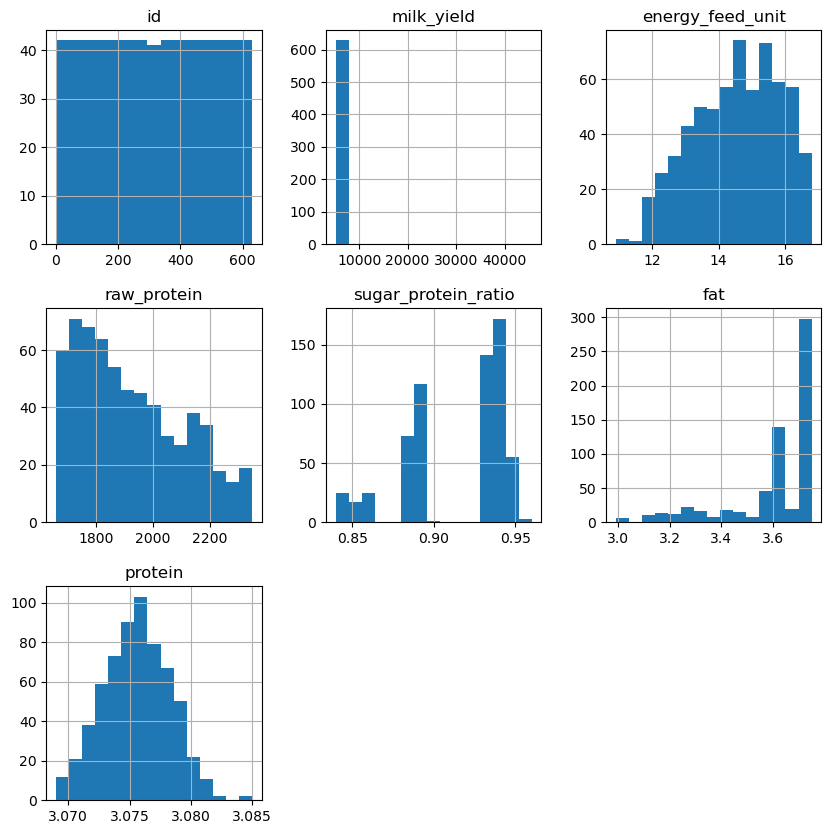

In [20]:
ferma_main.hist(figsize=(10, 10), bins=15)
None

Можно заметить, что почти не один из признаков (кроме `protein`) не имеет нормального распределения - где-то уклон вправо, где-то влево, где-то два пика, где-то данные кускообразные. Признак `milk_yield` имеет выброс.

Посмотрим пока на распределения в третьей таблице:

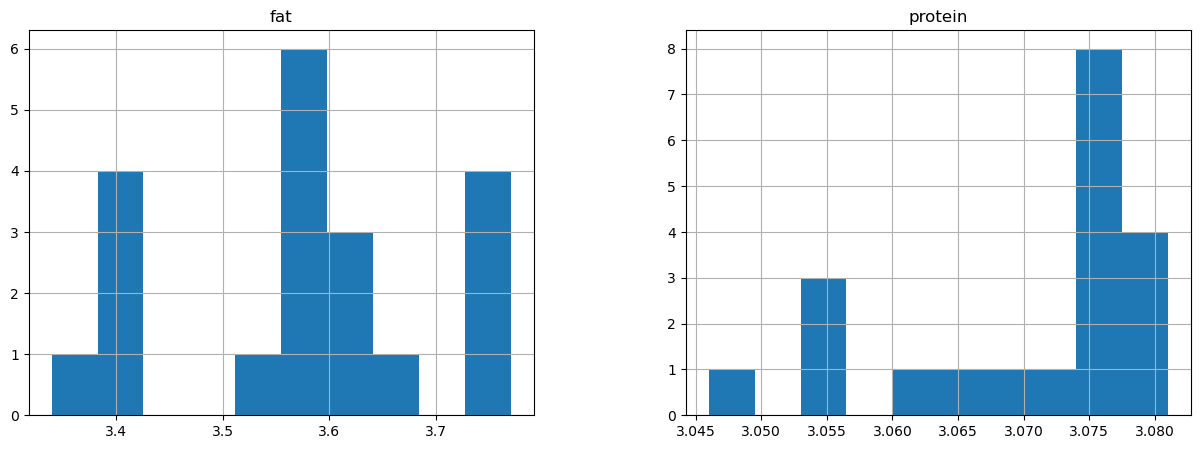

In [21]:
cow_buy.hist(figsize=(15, 5))
None

Как видим, данные так же фрагментарны.

Посмотрим на то, как представлены категориальные признаки в наших данных. Для удобства напишем функцию, которая строит круговую диаграмму по значениям категориального признака:

In [22]:
#dictionary with names of categorical columns
data_cat_columns = {
    'ferma_main':['breed', 'pasture_type', 'dad_breed','milk_taste', 'age'],
    'ferma_dad':['dad_name'],
    'cow_buy':['breed', 'pasture_type', 'dad_breed','dad_name']
}
dfs = {'cow_buy': cow_buy, 'ferma_main': ferma_main, 'ferma_dad': ferma_dad}

#function definition
def pie_builder(dict_df_index):
    for column in data_cat_columns[list(data_cat_columns.keys())[dict_df_index]]:
        fig1, ax1 = plt.subplots()
        df1 = pd.DataFrame(dfs[list(data_cat_columns.keys())[dict_df_index]].groupby([column])[column].count())
        ax1.pie(x=df1[column] ,labels=df1.index,autopct='%.1f')
        ax1.set_title(f'Распределение значений в таблице "{list(data_cat_columns.keys())[dict_df_index]}" в столбце "{column}"')
        plt.show()

Взглянем на распределение значений в категориальных признаках таблицы `ferma_main`:

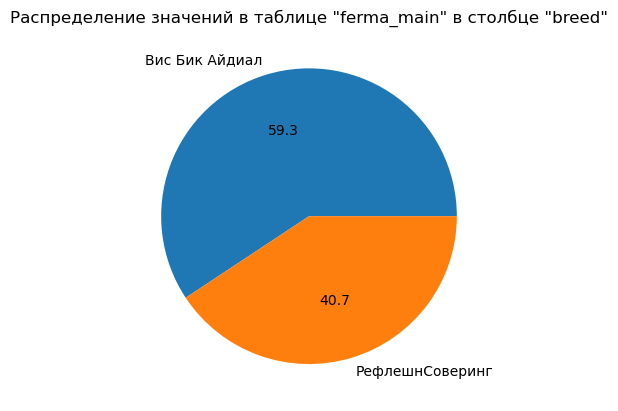

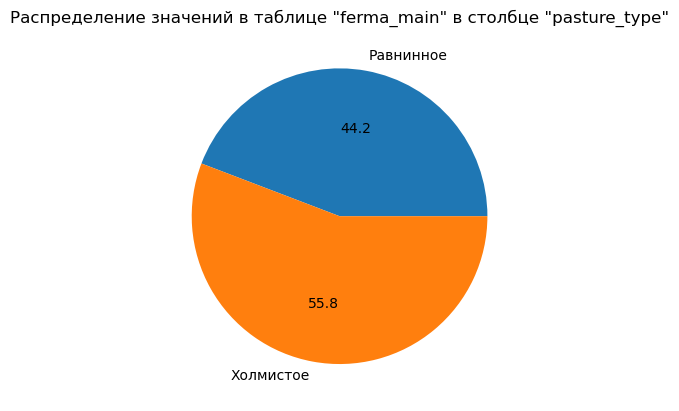

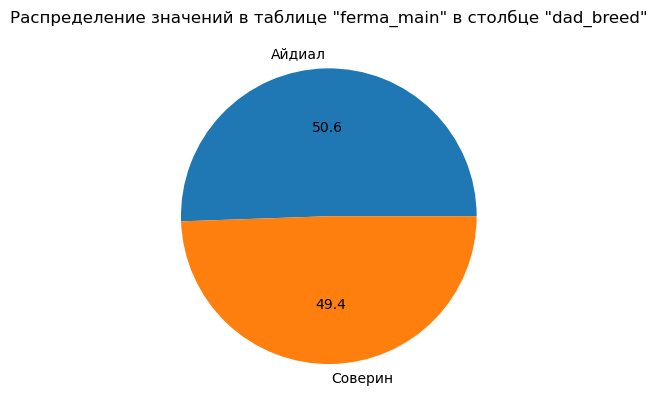

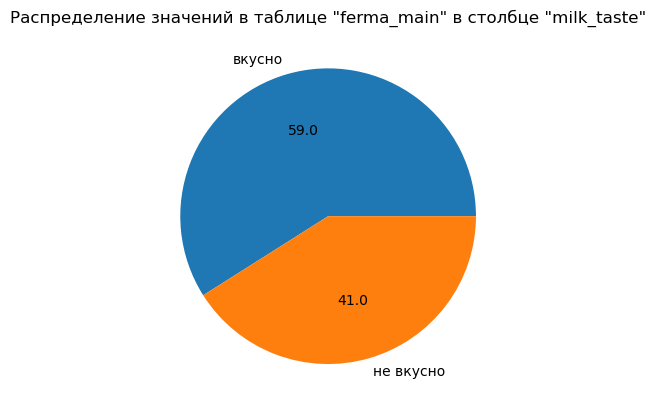

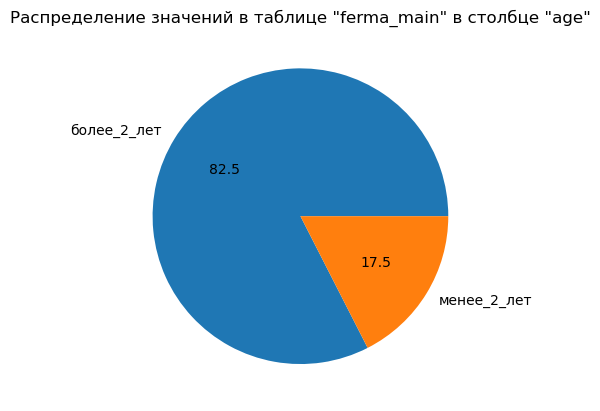

In [23]:
pie_builder(0)

Заметим, что:
- `~60%` коров имеют породу "Вис Бик Айдиал", `~40%` - "РефлешнСоверинг";
- `55.8%` коров паслись на холмистых лугах, `44.2%` - на равнинных;
- `50.6%` коров имеют отцов породы "Айдиал", `49.4%` - "Соверин";
- `~60%` молока коров - вкусное;
- Большинство коров (`82.5%`) имеют возраст более 2-х лет.

Построим графики для категориальных признаков таблицы `ferma_dad`:

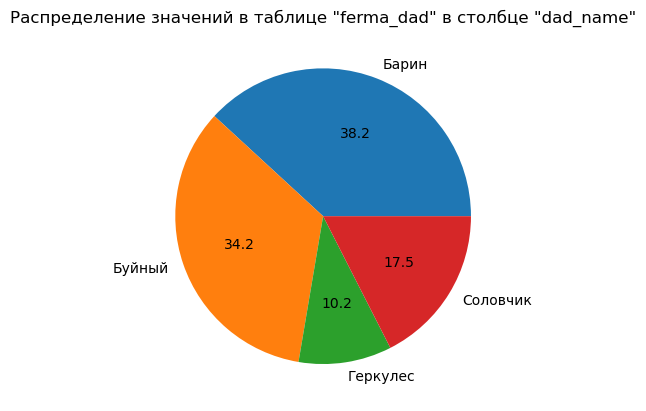

In [24]:
pie_builder(1)

Заметим, что:
- Представлено **4** разных коровы;
- Наиболее популярные - **Барин** и **Буйный**.

Построим графики для категориальных признаков таблицы `cow_buy`:

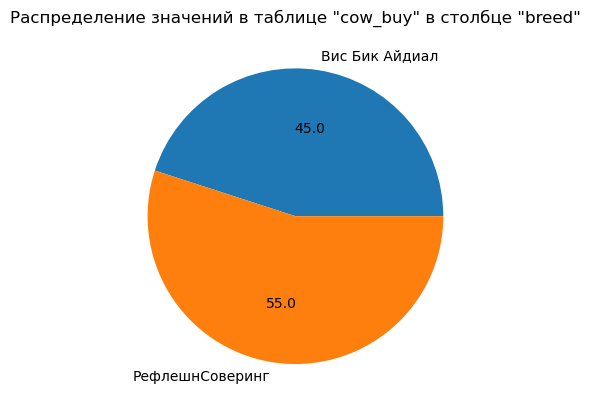

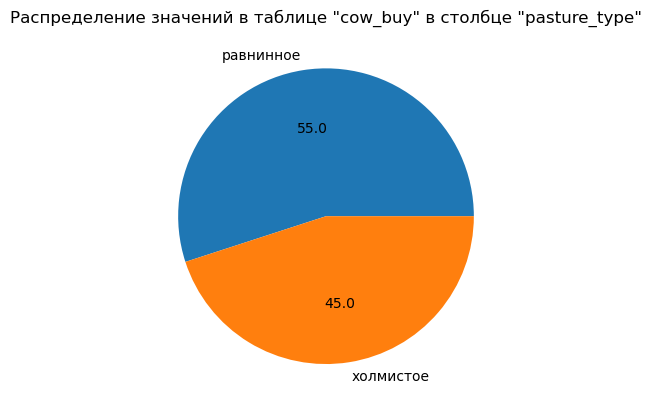

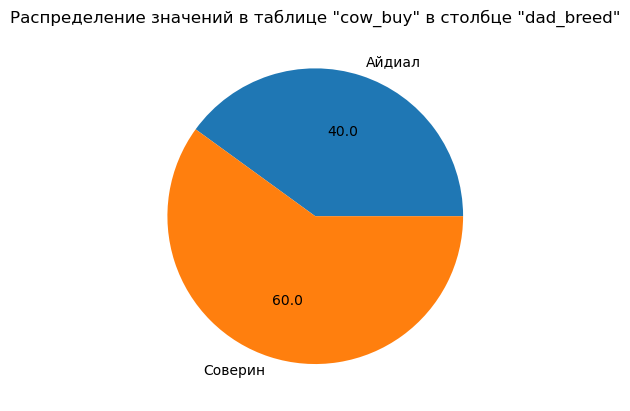

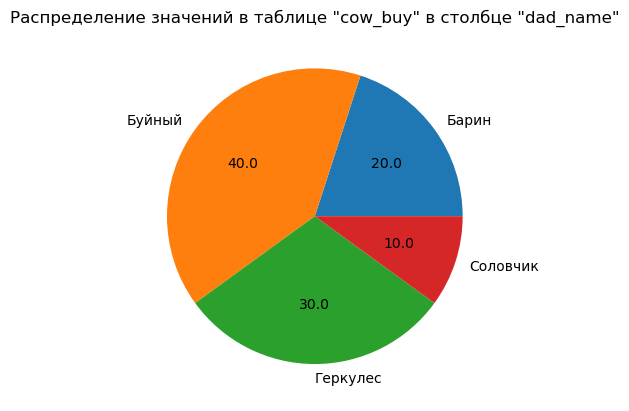

In [25]:
pie_builder(2)

Заметим, что:
- **Примерно половина** коров «ЭкоФермы» имеют породу **Вис Бик Айдиал**, половина - **РефлешнСоверинг**. Аналогично с типом пастбища `55/45`;
- Среди коров для покупки преобладают те, у кого папа - породы **Соверин** (`60%`)
- Среди коров для потенциальной попупки `40%` - коровы, у которых папу зовут **Буйный**, `30%` - **Геркулес**. `20%` - **Барин**, `10%` - **Соловичик**.

Посмотрим далее на статистические показатели наших данных:

In [26]:
ferma_main.describe()

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,fat,protein
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


In [27]:
cow_buy.describe()

,fat,protein
count,20.000000,20.000000
mean,3.577500,3.069500
std,0.126818,0.010339
min,3.340000,3.046000
25%,3.510000,3.064000
50%,3.590000,3.074000
75%,3.650000,3.076000
max,3.770000,3.081000


Заметим в таблице ferma_main **аномально высокое** значение в столбце `milk_yield` - `45616 кг` молока в год на корову при том, что средний показатель `6188 кг`, а `75%` данных меньше, чем `6501 кг`. Убедимся, что такое аномальное значение одно и удалим строчку с данной записью, чтобы та не влияла на статистики и прогнозную модель:

In [28]:
ferma_main["milk_yield"].sort_values(ascending=False).head()

16     45616
70      7222
135     7207
296     7201
294     7197
Name: milk_yield, dtype: int64

In [29]:
ferma_main = ferma_main.query('milk_yield < 45616').reset_index().drop(['index'], axis=1)
ferma_main["milk_yield"].sort_values(ascending=False).head()

69     7222
134    7207
295    7201
293    7197
592    7174
Name: milk_yield, dtype: int64

Для того, чтобы у датасетов была одинаковая размерность, удалим соответствующую запись из таблицы `ferma_dad`:

In [30]:
ferma_dad = ferma_dad.drop([16]).reset_index().drop(['index'], axis=1)

Готово. Записи по корове с id = 17 нет в таблицах.

Аномалия убрана, в остальном данные оптимальны для исследования.

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- Признаки в большинстве своём не имеют нормальное распределение, многин данные фрагментарно распределены. Исключение составляет `milk_yield` - данный признак почти склонен к нормальному распределению;
- `~60%` коров имеют породу 'Вис Бик Айдиал', `~40%` - 'РефлешнСоверинг';
- `55.8%` коров паслись на холмистых лугах, `44.2%` - на равнинных;
- `50.6%` коров имеют отцов породы 'Айдиал', `49.4%` - 'Соверин';
- `~60%` - вкусное;
- Большинство коров (`82.5%`) имеют возраст более `2-х лет`;
- Отец коровы - один из четырех имен. Наиболее популярные - 'Барин' и 'Буйный';
- `50%` коров 'ЭкоФермы' имеют породу 'Вис Бик Айдиал', `50%` - 'РефлешнСоверинг'
- `50%` коров 'ЭкоФермы' паслись на холмистых пастбищах, другие - на холмистых;
- Среди коров для покупки преобладают те, у кого папа - породы 'Соверин' (`62.5%`)
- Среди коров для потенциальной попупки 40% - коровы, у которых папу зовут Геркулес, 30% - Буйный. 20% - Барин, 10% - Соловичик;
- Удалена сточка, где в столбце "milk_yield" аномальное значение - `45616кг` молока.
</div>

## Корреляционный анализ данных <a id='5'></a>

Взглянем дальше на корреляционные составляющие входных признаков:

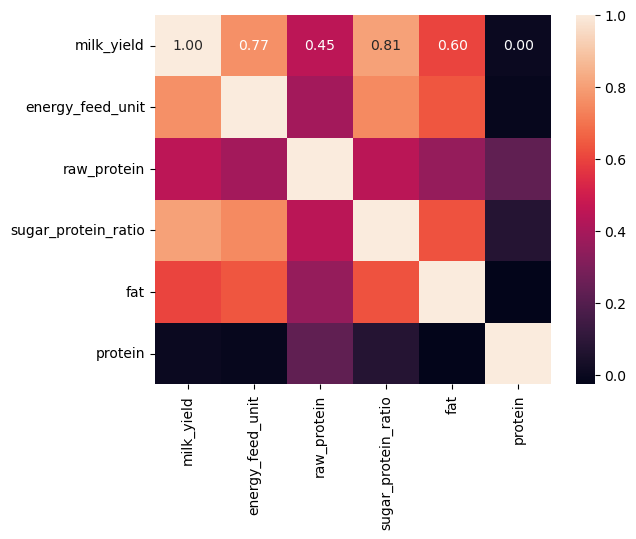

In [31]:
sns.heatmap(ferma_main[['milk_yield', 'energy_feed_unit', 'raw_protein',
       'sugar_protein_ratio', 'fat',
       'protein']].corr(), annot=True, fmt=".2f")
None

C удоем коррелирует почти всё, кроме содержания белка. Примечательно, что белок никаким образом не коррелирует с другими входными признаками. Слабая корреляция с другими признакми также и у содержания сырого протеина в корме. Корреляцию с удоем также имеют такие признаки, как Энергетическая кормовая единица, Сахаро-протеиновое соотношение.

Посмотрим на коэффицент Спирмена:

In [32]:
a, b = spearmanr(ferma_main['energy_feed_unit'], ferma_main['fat'])
print(a, b)

0.6869728114955576 7.375381778178118e-89


In [33]:
a, b = spearmanr(ferma_main['energy_feed_unit'], ferma_main['sugar_protein_ratio'])
print(a, b)

0.7419617884362985 8.604461213395716e-111


In [34]:
a, b = spearmanr(ferma_main['fat'], ferma_main['sugar_protein_ratio'])
print(a, b)

0.70104404877437 5.445607413423395e-94


In [35]:
a, b = spearmanr(ferma_main['energy_feed_unit'], ferma_main['milk_yield'])
print(a, b)

0.7651443116006692 8.359783320590879e-122


Напишем алгоритм, который будет визуализировать корреляции с помощью диаграмм рассеяния:

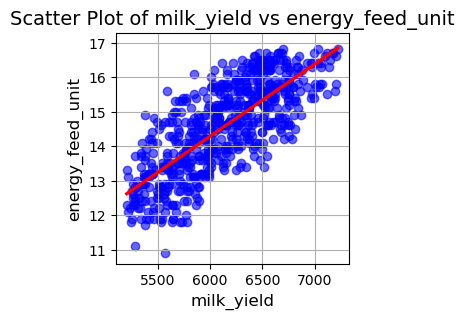

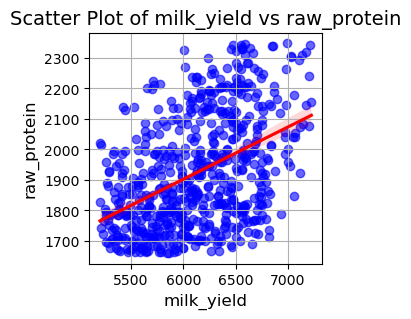

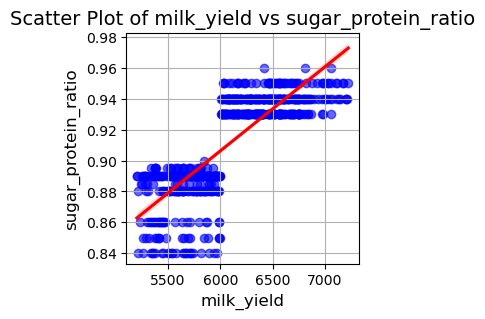

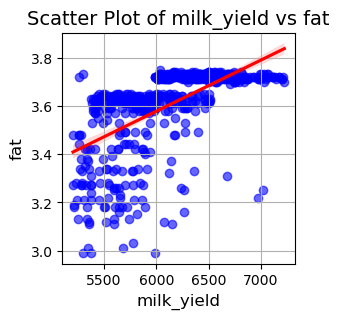

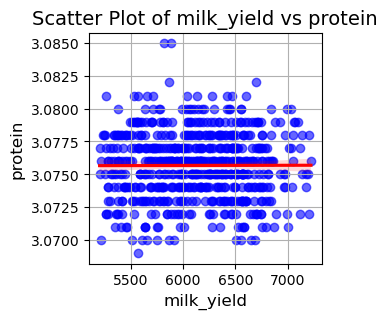

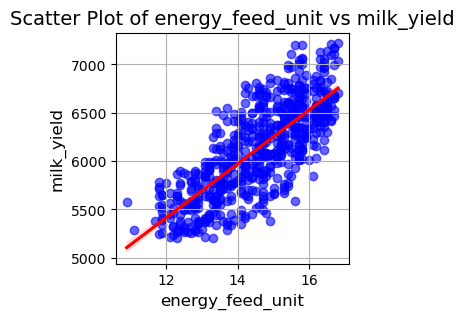

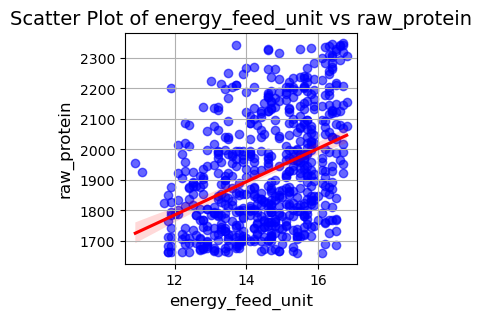

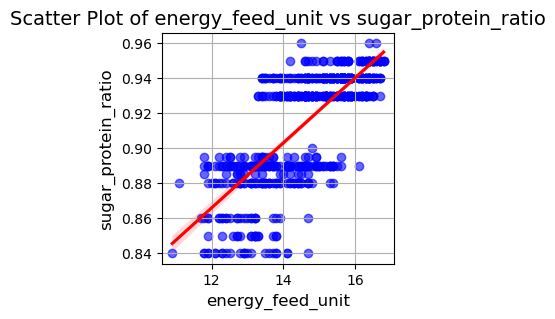

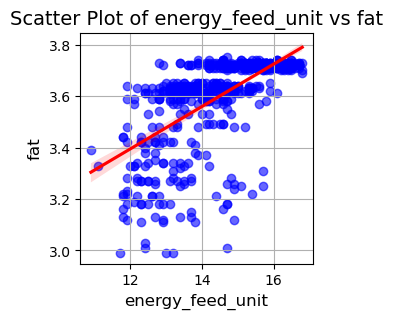

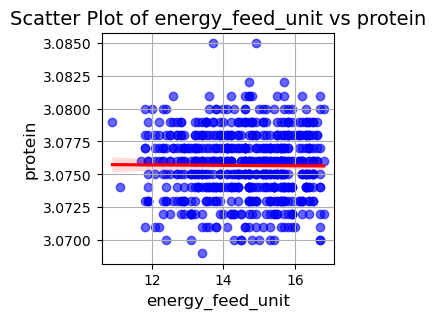

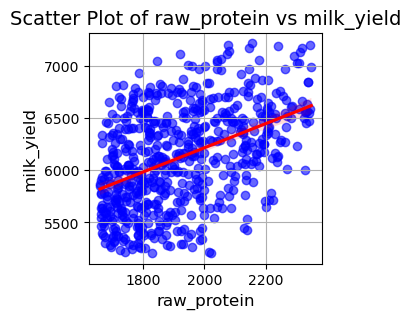

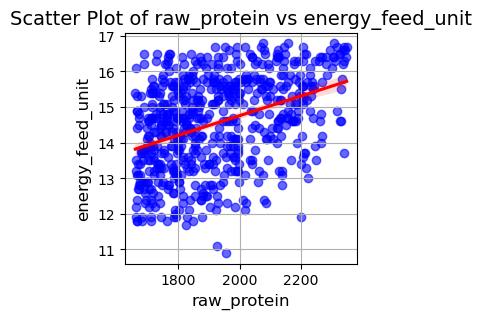

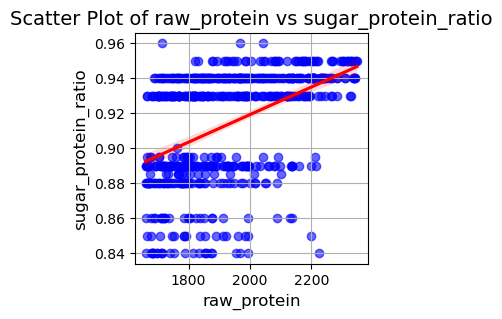

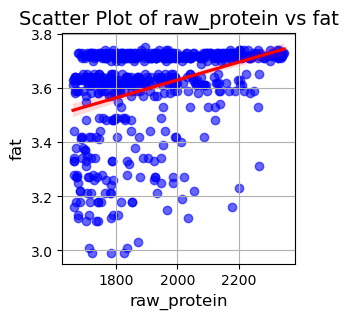

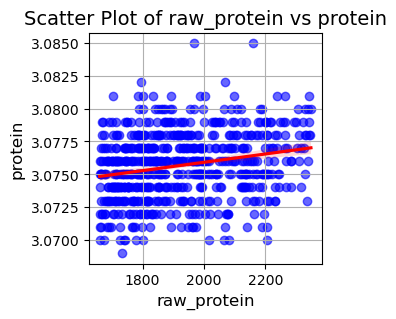

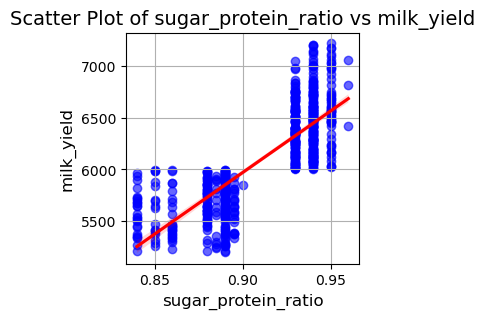

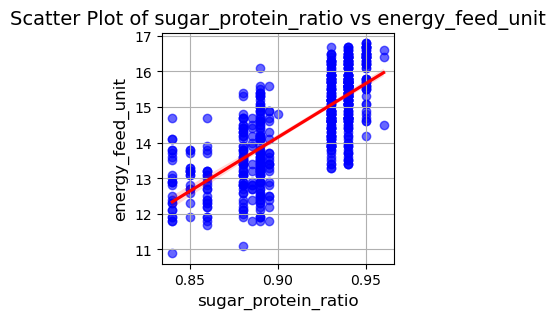

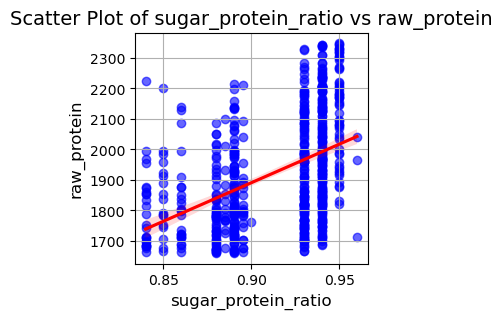

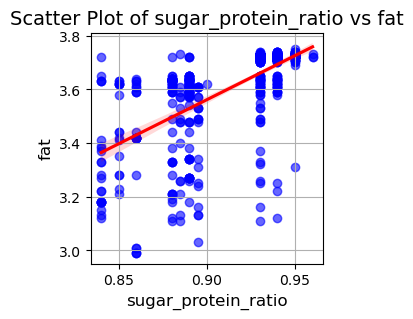

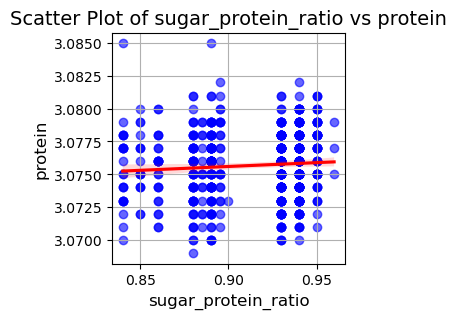

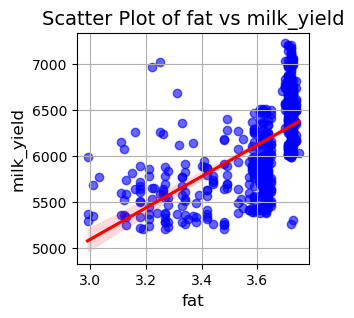

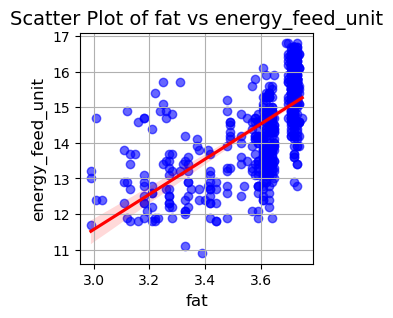

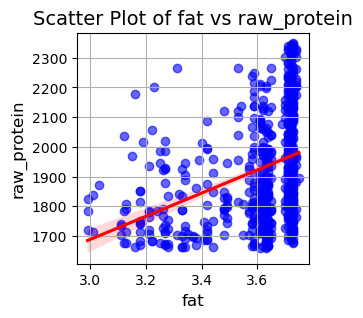

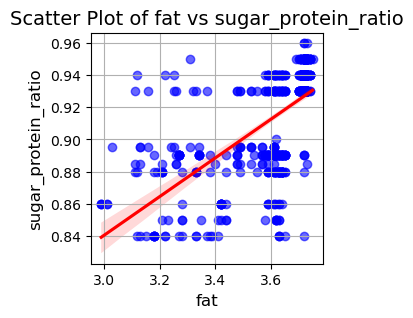

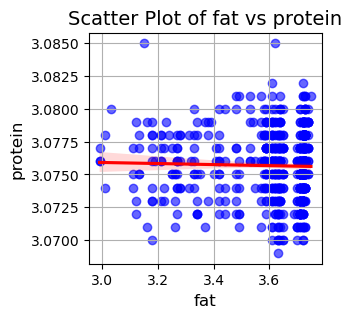

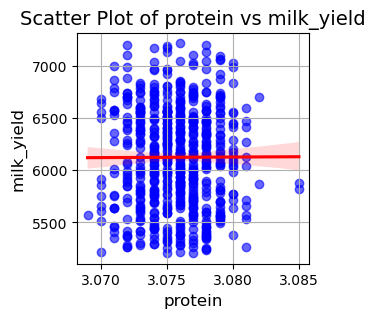

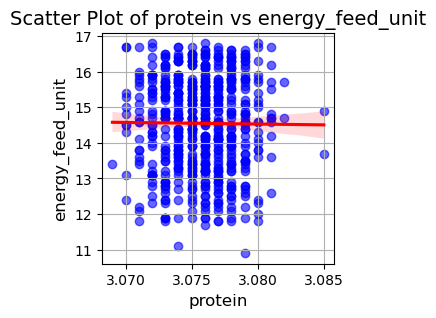

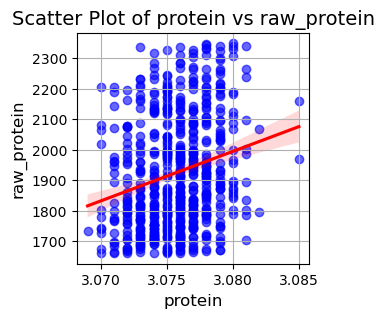

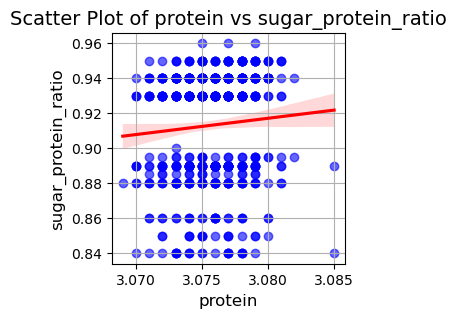

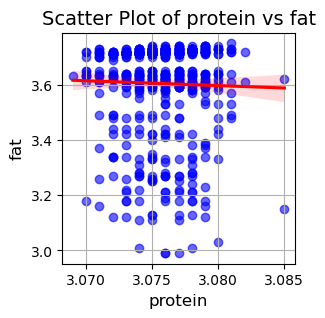

In [36]:
for indicator_x in ['milk_yield', 'energy_feed_unit', 'raw_protein',
       'sugar_protein_ratio', 'fat', 'protein']:
    for indicator_y in ['milk_yield', 'energy_feed_unit', 'raw_protein',
       'sugar_protein_ratio', 'fat', 'protein']:
        if indicator_x != indicator_y:
            fig1, ax1 = plt.subplots(figsize=(3, 3))
            
            ax1.scatter(ferma_main[indicator_x], ferma_main[indicator_y], alpha=0.6, c='blue')
            
            sns.regplot(x=ferma_main[indicator_x], y=ferma_main[indicator_y], scatter=False, ax=ax1, color='red')
            
            plt.xlabel(indicator_x, fontsize=12)
            plt.ylabel(indicator_y, fontsize=12)
            plt.title(f'Scatter Plot of {indicator_x} vs {indicator_y}', fontsize=14)
            
            ax1.grid(True)

            plt.show()

- Очевидной четкой линейной регресии среди входных признаков не наблюдается
- Как было ранее отмечено, присутствует корреляция между входными и целевым признаком, что нормально.
- Среди таких признаков как `fat`, `energy_feed_unit`, `sugar_protein_ratio` присутствует заметная статистически значимая корреляции, что негативно скажется на качетсве модели
- Некоторые признаки связаны с целевым **нелинейно**

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- Между целевым признаком и входными признакми **есть корреляция**
- Среди входных признаков есть несильная, порой нелинейная корреляция. Однако так как в модель МО будут включаться только те признаки, которые подходят для обучения (ЭКЕ, Сырой протеин и СПО - не влияют на Удой), проблемы мультиколлинеарности можно избежать, грамотно подобрав параметры, доп. факторы вводить не нужно.
- Распределение значений либо не нормальное, либо частино нормальное
- Параметр содержание белка не коррелирует ни с каким из признаков
</div>

## Обучение модели линейной регрессии <a id='6'></a>

### Модель 1

- Сформируем датасет с входными признаками - для этого удалим из общей таблицы ряд признаков, не влияющих на целевую переменную - `milk_yield`, `fat`, `protein`, `milk_taste`, `id`. Далее создадим датафрейм с целевой переменной.
- Признаки `energy_feed_unit`, `raw_protein`, `sugar_protein_ratio`, `breed`, `pasture_type`, `dad_breed`, `age` влияют на зависимую переменную, поэтому должны быть включены в перечень входных признаков.

In [37]:
X = ferma_main.drop(['milk_yield', 'fat', 'protein', 'milk_taste', 'id'], axis=1)
y = ferma_main['milk_yield']

In [38]:
X.head()

,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,age
0,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет
1,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет
2,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,более_2_лет
3,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет
4,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет


In [39]:
y.head()

0    5863
1    5529
2    5810
3    5895
4    5302
Name: milk_yield, dtype: int64

Далее разобьем данные на выборки:

In [40]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

Стандартизируем и закодируем признаки:

In [41]:
ct = ColumnTransformer([
       ('scale', StandardScaler(),
       make_column_selector(dtype_include=np.number)),
       ('onehot', OneHotEncoder(drop='first', sparse_output=False),
       make_column_selector(dtype_include=object))])

In [42]:
X_train = pd.DataFrame(ct.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(ct.transform(X_test), columns=X_test.columns)

Признаки масштабированы, далее обучим нашу модель:

In [43]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

predictions = model_lr.predict(X_test)

Рассчитаем коэффициент детерминации R^2:

In [44]:
r2_lr = r2_score(y_test, predictions)
r2_lr

0.7844078173416966

Как можно заметить, значение метрики равно `78%`, следовательно учтенные **факторы на 78% объясняют целевой**.

Далее рассчитаем остатки и проанализируем их с помощью графиков. Для удобства переиспользования напишем функцию:

In [45]:
def residuals_predictions_charts(y_test, predictions):
    residuals = y_test - predictions
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

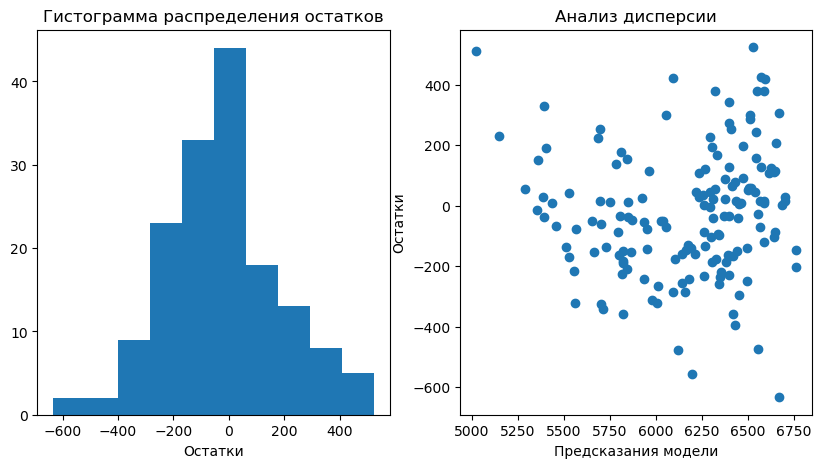

In [46]:
residuals_predictions_charts(y_test, predictions)

Гистограмма распределения остатков имеет `симметеричное нормальное распределение`. Анализ дисперсии показал в целом расброс случаен, но с ростом значений предсказания моделей разброс остатков слегка увеличивается.

**Вывод**: модель работает неплохо, но не идеально. R^2 равен 0.78, значит модель показывает целевой признак лучше чем если бы это рассчитывалось по среднему. Анализ остатков показал, что они нормально и симметрично распределены, однако с ростом предсказываемого значения слегка увеличивается разброс остатков.

### Модель 2

In [47]:
ferma_main.head()

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat,protein,milk_taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


СПО и Удой связаны нелинейно. Исключим нелинейность: переведем `sugar_protein_ratio` в категориальный признак, выявив и использовав **границу нелинейности**.

Для начала построим опять график и убедимся в нелинейности:

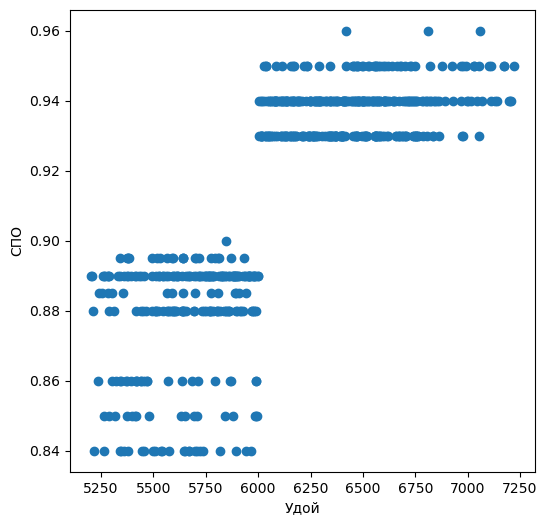

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(ferma_main['milk_yield'], ferma_main['sugar_protein_ratio'])
plt.xlabel('Удой')
plt.ylabel('СПО')
plt.show
None

Определим гранцы отнесения к категориям:

In [49]:
ferma_main.query(' .92 > sugar_protein_ratio > .91')

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat,protein,milk_taste,age


Заметим, что при границе нелинейнойсти, равной 0.91 данные делятся на две категории примерно равного количетва. Присвоим записям в данном столбце значение 0, если СПО < 0.91 и 1, если СПО > 0.91:

Напишем функцию для присваивания категории:

In [50]:
def sugar_protein_ratio_classifier(spr):
    if spr > .91:
        return '1'
    return '0'

Создадим столбец с категорией:

In [51]:
ferma_main['sugar_protein_ratio_classified'] = ferma_main['sugar_protein_ratio'].apply(sugar_protein_ratio_classifier)

In [52]:
ferma_main['sugar_protein_ratio_classified'].value_counts()

sugar_protein_ratio_classified
1    370
0    258
Name: count, dtype: int64

In [53]:
ferma_main.head()

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat,protein,milk_taste,age,sugar_protein_ratio_classified
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0


Введем **новый признак** ЭКЕ в квадрате (`energy_feed_unit_squared`)

In [54]:
ferma_main['energy_feed_unit_squared'] = ferma_main['energy_feed_unit']**2
ferma_main.head()

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat,protein,milk_taste,age,sugar_protein_ratio_classified,energy_feed_unit_squared
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84


Повторим предыдущие этапы с подготовкой данных к обучению с учетом новых признаков:

In [55]:
X = ferma_main.drop(['milk_yield', 'fat', 'protein', 'milk_taste', 'id', 'sugar_protein_ratio', 'energy_feed_unit'], axis=1)
y = ferma_main['milk_yield']

In [56]:
X.head()

,raw_protein,breed,pasture_type,dad_breed,age,sugar_protein_ratio_classified,energy_feed_unit_squared
0,1743,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,0,201.64
1,2138,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,0,163.84
2,1854,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,0,196.00
3,2012,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,0,153.76
4,1675,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,0,163.84


In [57]:
RANDOM_STATE = 42

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

In [58]:
X_train_2 = pd.DataFrame(ct.fit_transform(X_train_2), columns=X_train_2.columns)
X_test_2 = pd.DataFrame(ct.transform(X_test_2), columns=X_test_2.columns)

Обучим модель линейной регрессии с учетом новых признаков:

In [59]:
model_lr_2 = LinearRegression()

model_lr_2.fit(X_train_2, y_train_2)

predictions2 = model_lr_2.predict(X_test_2)

In [60]:
r2_lr_2 = r2_score(y_test_2, predictions2)
r2_lr_2

0.8180879926867503

Как видим, модель стала лучще. Учтенные факторы на `~82%` объясняют целевой.

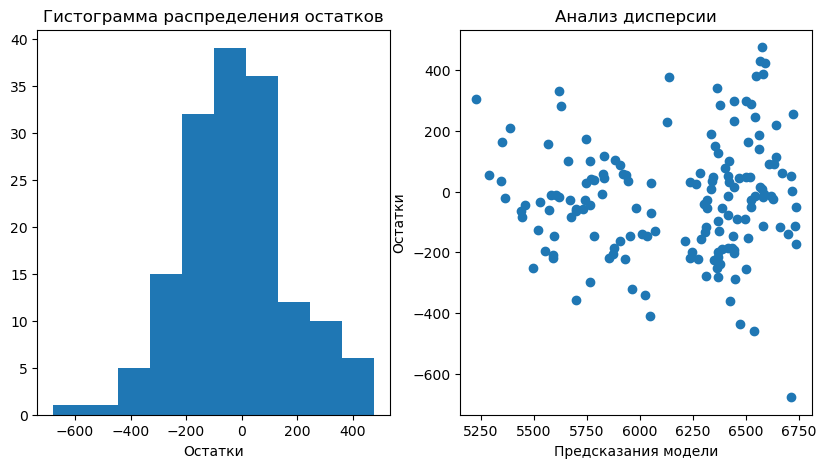

In [61]:
residuals_predictions_charts(y_test_2, predictions2)

Можно заметить, что распределение остатков всё также имеет нормальное распределение. Говоря про анализ дисперсии, можно сказать, что разброс остатков концептуально не изменился во второй модели.

### Модель 3

Далее соединим таблицы 1 и 3, чтобы построить модель линейной регрессии с учётом нового признака из файла `ferma_dad.csv`:

In [62]:
ferma_main_merged = ferma_main.merge(ferma_dad, on=['id'])
ferma_main_merged.head()

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat,protein,milk_taste,age,sugar_protein_ratio_classified,energy_feed_unit_squared,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,Барин


In [63]:
X = ferma_main_merged.drop(['milk_yield', 'fat', 'protein', 'milk_taste', 'id', 'sugar_protein_ratio', 'energy_feed_unit'], axis=1)
y = ferma_main_merged['milk_yield']

Кодируем категориальный признак "dad_name":

In [64]:
RANDOM_STATE = 42

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

In [65]:
X_train_3 = pd.DataFrame(ct.fit_transform(X_train_3), columns=ct.get_feature_names_out())
X_test_3 = pd.DataFrame(ct.transform(X_test_3), columns=ct.get_feature_names_out())

Обучим третью модель:

In [66]:
model_lr_3 = LinearRegression()

model_lr_3.fit(X_train_3, y_train_3)

predictions3 = model_lr_3.predict(X_test_3)

In [67]:
r2_lr_3 = r2_score(y_test_3, predictions3)
r2_lr_3

0.8247542745210406

Как видим, модель стала еще чуть точнее. Коэффициент детерминации теперь стал равен `0.824`.

Рассчитаем остатки и построим соответствующие графики:

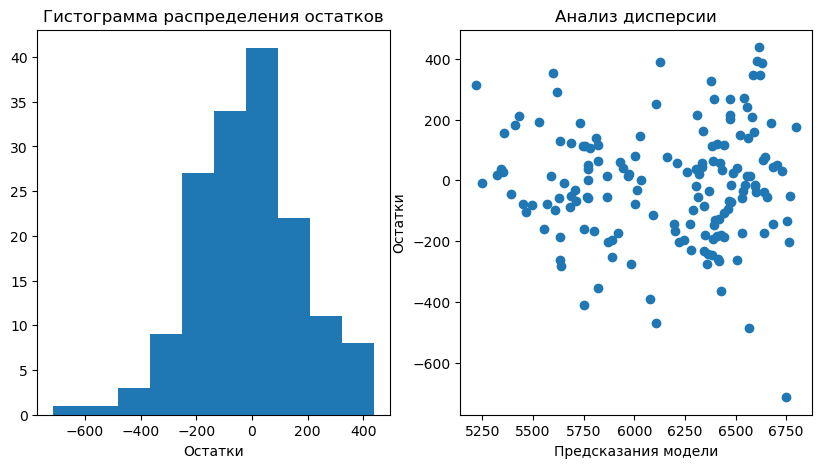

In [68]:
residuals_predictions_charts(y_test_3, predictions3)

Распределение остатков имеет симметриченое нормальное распределение, однако левый рупор на графике анализа также имеет место.

### Сравнение 3-х моделей

Сравним качество трёх моделей линейной регрессии, сопоставим их R² и остатки:

In [69]:
print('R² Модели №1: ', round(r2_lr, 3))
print('R² Модели №2: ', round(r2_lr_2, 3))
print('R² Модели №3: ', round(r2_lr_3, 3))

R² Модели №1:  0.784
R² Модели №2:  0.818
R² Модели №3:  0.825


R² наиболее точен у **модели 3**. Следовательно, признаки подобраны в этой модели лучше, и она лучше предсказывает значения целевого параметра.

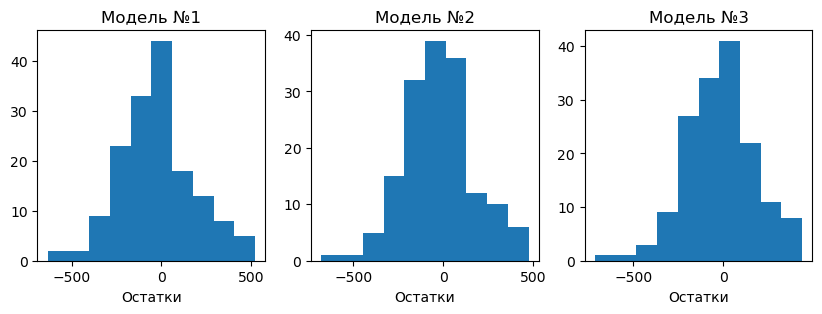

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
axes[0].hist(y_test - predictions)
axes[0].set_title('Модель №1')
axes[0].set_xlabel('Остатки')

axes[1].hist(y_test_2 - predictions2)
axes[1].set_title('Модель №2')
axes[1].set_xlabel('Остатки')

axes[2].hist(y_test_3 - predictions3)
axes[2].set_title('Модель №3')
axes[2].set_xlabel('Остатки')

plt.show()

Распределение у модели №3 также стало наилучшее. В модели №2 оно ухудшилось по сравнению с №1.

### Расчёт метрик

Рассчитаем точность каждой модели по трём другим метрикам: MSE, MAE, RMSE:

In [71]:
metrics_df = pd.DataFrame(columns = ['Модель №1', 'Модель №2', 'Модель №3'], index=['R²', 'MSE', 'RMSE', 'MAE'])
metrics_df['Модель №1'] = [
    round(r2_lr, 3),
    mean_squared_error(y_test, predictions),
    mean_squared_error(y_test, predictions)**0.5,
    mean_absolute_error(y_test, predictions)
]
metrics_df['Модель №2'] = [
    round(r2_lr_2, 3),
    mean_squared_error(y_test_2, predictions2),
    mean_squared_error(y_test_2, predictions2)**0.5,
    mean_absolute_error(y_test_2, predictions2)
]
metrics_df['Модель №3'] = [
    round(r2_lr_3, 3),
    mean_squared_error(y_test_3, predictions3),
    mean_squared_error(y_test_3, predictions3)**0.5,
    mean_absolute_error(y_test_3, predictions3)
]
metrics_df

,Модель №1,Модель №2,Модель №3
R²,0.784000,0.818000,0.825000
MSE,43887.015010,37030.911311,35673.889886
RMSE,209.492279,192.434174,188.875329
MAE,164.241945,149.039652,146.163024


Найдем доверительный интервал для этой модели. Для этого посчитаем `0.025` и `0.975` `квантили`:

In [72]:
print(f'С вероятностью 95% удой будет находиться в интервале от \
{round(np.quantile(predictions3, .025))}кг до {round(np.quantile(predictions3, .975))}кг')

С вероятностью 95% удой будет находиться в интервале от 5351кг до 6749кг


### Прогноз удоя коров

Применим третью модель к данным из датасета `cow_buy.csv` и спрогнозируем удой коров, которых фермер хочет купить.

- Параметры кормления ЭКЕ, Сырой протеин, СПО отсутствуют в `cow_buy`, но по условию фермер планирует увеличить средние значения ЭКЕ, Сырой протеин, СПО на 5%.
- Поэтому вставим соответствующие средние значения в таблицу `cow_buy` и увеличим их на `5%`.Значения возраста поставим как `1`.

In [73]:
cow_buy['energy_feed_unit_squared'] = (ferma_main.energy_feed_unit.mean()*1.05)**2
cow_buy['raw_protein'] = ferma_main.raw_protein.mean()*1.05
cow_buy['sugar_protein_ratio_classified'] = sugar_protein_ratio_classifier(ferma_main.sugar_protein_ratio.mean()*1.05)
cow_buy['age'] = 1

In [74]:
cow_buy.head()

,breed,pasture_type,dad_breed,dad_name,fat,protein,energy_feed_unit_squared,raw_protein,sugar_protein_ratio_classified,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,233.361138,2019.947532,1,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,233.361138,2019.947532,1,1
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,233.361138,2019.947532,1,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,233.361138,2019.947532,1,1
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,233.361138,2019.947532,1,1


Далее нормализуем данныы, применив One-Hot Encoding и StandardScaler к признакам из таблицы `cow_buy.csv`:

In [75]:
cat_col_names_buy = ["breed", "pasture_type", "dad_breed"]

encoder = OneHotEncoder(drop='first', sparse_output=False)

cow_buy_ohe = encoder.fit_transform(cow_buy[cat_col_names_buy])

encoder_col_names_buy = encoder.get_feature_names_out()

cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=cat_col_names_buy).reset_index().drop(['index'], axis=1)

In [76]:
num_col_names = ['energy_feed_unit_squared', 'raw_protein']

scaler = StandardScaler()

cow_buy_scaled = scaler.fit_transform(cow_buy[num_col_names])

cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names).reset_index().drop(['index'], axis=1)

In [77]:
cow_buy_dad_name_ohe = encoder.fit_transform(np.array(cow_buy['dad_name']).reshape(-1,1))

encoder_for_dad_name_col_names = encoder.get_feature_names_out()

df_cow_buy_dad_name_ohe = pd.DataFrame(cow_buy_dad_name_ohe, columns=encoder_for_dad_name_col_names)

In [78]:
cow_buy_concat = pd.concat([cow_buy_ohe, cow_buy_scaled, df_cow_buy_dad_name_ohe], axis=1)
cow_buy_concat['sugar_protein_ratio_classified'] = sugar_protein_ratio_classifier(ferma_main.sugar_protein_ratio.mean()*1.05)
cow_buy_concat['age'] = 1
cow_buy_concat.head()

,breed,pasture_type,dad_breed,energy_feed_unit_squared,raw_protein,x0_Буйный,x0_Геркулес,x0_Соловчик,sugar_protein_ratio_classified,age
0,0.0,1.0,0.0,0.0,4.547474e-13,0.0,1.0,0.0,1,1
1,0.0,0.0,1.0,0.0,4.547474e-13,1.0,0.0,0.0,1,1
2,1.0,0.0,1.0,0.0,4.547474e-13,0.0,0.0,0.0,1,1
3,1.0,1.0,0.0,0.0,4.547474e-13,1.0,0.0,0.0,1,1
4,1.0,0.0,0.0,0.0,4.547474e-13,1.0,0.0,0.0,1,1


Теперь можно делать предсказание модели:

In [79]:
cow_buy_concat.columns = X_test_3.columns

In [80]:
predictions_cow_buy = model_lr_3.predict(cow_buy_concat)

In [81]:
cow_buy['milk_yield_predicted'] = predictions_cow_buy
cow_buy.head()

,breed,pasture_type,dad_breed,dad_name,fat,protein,energy_feed_unit_squared,raw_protein,sugar_protein_ratio_classified,age,milk_yield_predicted
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,233.361138,2019.947532,1,1,6631.071482
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,233.361138,2019.947532,1,1,5937.274786
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,233.361138,2019.947532,1,1,6181.858812
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,233.361138,2019.947532,1,1,6136.778261
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,233.361138,2019.947532,1,1,5974.390469


<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- В процессе обучения модели линейной регрессии было создано `три варианта модели`: а) модель линейной регрессии на данных датасета farm_main б) модель линейной регрессии с преобразованными признаками, нелинейно связанных с целевым признаком, - СПО и ЭКЕ в) модель линейной регрессии с учётом нового признака - имени папы коровы
- Третий вариант модели показал себя `лучше` всего: `R²` = 0.84.
- Третья модель была применена к данными продавца коров с учетом `допущений`, касающихся таких признаков, как ЭКЕ, Сырой протеин, СПО и возраст.
- `Предсказания` были внесены в таблицу
</div>

## Обучение модели логистической регрессии <a id='7'></a>

Построим далее модель логистической регрессии на основании данных таблицы `farm_main`. Целевым признаком будет `milk_taste`.

Взлянем на данные:

In [82]:
ferma_main_merged.head()

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat,protein,milk_taste,age,sugar_protein_ratio_classified,energy_feed_unit_squared,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,Барин


Разделим данные на признаковое описание и целевой признак. В признаках появятся два новых признака - `fat` и `proten` - необходимые для предсказания вкуса молока.

In [83]:
X_log = ferma_main_merged[
    ['raw_protein', 'breed', 'pasture_type',
 'dad_breed', 'fat', 'protein', 'age',
 'sugar_protein_ratio_classified','energy_feed_unit_squared', 'dad_name']
]
y_log = ferma_main_merged['milk_taste']

Масштабируем данные столбца `dad_name`:

In [84]:
X_log_ohe = encoder.fit_transform(np.array(X_log.dad_name).reshape(-1,1))

encoder_for_dad_name_col_names = encoder.get_feature_names_out()

df_X_log_ohe = pd.DataFrame(X_log_ohe, columns=encoder_for_dad_name_col_names)

X_log = pd.concat([X_log, df_X_log_ohe], axis=1)

Сфоримуем тренировочные и тестовые выборки:

In [85]:
RANDOM_STATE = 42

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log,
    y_log,
    random_state=RANDOM_STATE
)

Нормализуем и масштабируем данные:

In [86]:
cat_col_names_log = ['breed', 'pasture_type', 'dad_breed', 'age']

X_train_log_ohe = encoder.fit_transform(X_train_log[cat_col_names_log])
X_test_log_ohe = encoder.transform(X_test_log[cat_col_names_log])

encoder_col_names_log = encoder.get_feature_names_out()

X_train_log_ohe = pd.DataFrame(X_train_log_ohe, columns=cat_col_names_log)
X_test_log_ohe = pd.DataFrame(X_test_log_ohe, columns=cat_col_names_log)

In [87]:
num_col_names_log = ['energy_feed_unit_squared', 'raw_protein', 'fat', 'protein']

scaler = StandardScaler()

X_train_log_scaled = scaler.fit_transform(X_train_log[num_col_names_log])
X_test_log_scaled = scaler.transform(X_test_log[num_col_names_log])

X_train_log_scaled = pd.DataFrame(X_train_log_scaled, columns=num_col_names_log)
X_test_log_scaled = pd.DataFrame(X_test_log_scaled, columns=num_col_names_log)

In [88]:
X_train_log_scaled.head()

,energy_feed_unit_squared,raw_protein,fat,protein
0,1.577968,1.079523,0.562532,-0.679069
1,-1.511438,-0.196920,-1.601817,-1.452568
2,0.082269,-1.386085,-2.563750,1.254677
3,-0.150235,0.752230,0.081565,1.254677
4,-1.102358,0.828598,0.201807,0.094429


Соеденим данные в единые таблицы 'X_train_log_concat' и 'X_test_log_concat':

In [89]:
X_log.columns

Index(['raw_protein', 'breed', 'pasture_type', 'dad_breed', 'fat', 'protein',
       'age', 'sugar_protein_ratio_classified', 'energy_feed_unit_squared',
       'dad_name', 'x0_Буйный', 'x0_Геркулес', 'x0_Соловчик'],
      dtype='object')

In [90]:
X_train_log_concat = pd.concat([X_train_log_ohe, X_train_log_scaled, X_train_log[['x0_Буйный', 'x0_Геркулес', 'x0_Соловчик']].reset_index().drop(['index'], axis=1)], axis=1)
X_test_log_concat = pd.concat([X_test_log_ohe, X_test_log_scaled, X_test_log[['x0_Буйный', 'x0_Геркулес', 'x0_Соловчик']].reset_index().drop(['index'], axis=1)],axis=1)

In [91]:
X_train_log_concat['sugar_protein_ratio_classified'] = sugar_protein_ratio_classifier(ferma_main.sugar_protein_ratio.mean()*1.05)
X_test_log_concat['sugar_protein_ratio_classified'] = sugar_protein_ratio_classifier(ferma_main.sugar_protein_ratio.mean()*1.05)

Обучим нашу модель и предскажем значения целевого признака:

In [92]:
model_log = LogisticRegression() 

model_log.fit(X_train_log_concat, y_train_log)

predictions_log = model_log.predict(X_test_log_concat)

Построим матрицу ошибок:

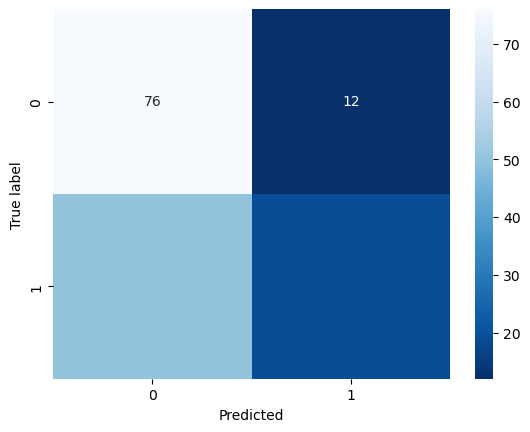

In [93]:
cm = confusion_matrix(y_test_log, predictions_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
None

Поясним, какие значения относятся к `0`, какие - к `1`:
- 0 - `вкусно`
- 1 - `не вкусно`

Посчитаем метрики качества модели:

In [94]:
accuracy = accuracy_score(y_test_log, predictions_log)
recall = recall_score(y_test_log, predictions_log, pos_label='не вкусно')
precision = precision_score(y_test_log, predictions_log, pos_label='не вкусно')

In [95]:
print('Accuracy: ', round(accuracy, 3))
print('Recall: ', round(recall ,3))
print('Precision: ', round(precision,3))

Accuracy:  0.605
Recall:  0.275
Precision:  0.613


При покупке коров критичнее всего `ложно-отрицательная ошибка`, поскольку в таком лучае фермер купит корову, которая, как он предполагает будет давать вкусное молоко, а она даст невкусное. Следовательно, необходимо повысить метрику `recall`.

In [96]:
y_proba = model_log.predict_proba(X_test_log_concat)[:,1]

data = pd.DataFrame(zip(y_test_log, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

data.head()

,y_valid,y_proba
84,не вкусно,0.761756
102,вкусно,0.709481
46,не вкусно,0.679909
144,не вкусно,0.677416
23,вкусно,0.669949


In [97]:
thresholds = [round(i,2) for i in np.linspace(0.5,1,num = 6,endpoint=False)]
print(thresholds)

[0.5, 0.58, 0.67, 0.75, 0.83, 0.92]


In [98]:
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 'не вкусно' if x >= i else 'вкусно')
# выведем 5 случайных строк
print(data.sample(5))

       y_valid   y_proba y_pred_0.5 y_pred_0.58 y_pred_0.67 y_pred_0.75  \
0       вкусно  0.421570     вкусно      вкусно      вкусно      вкусно   
144  не вкусно  0.677416  не вкусно   не вкусно   не вкусно      вкусно   
154     вкусно  0.377201     вкусно      вкусно      вкусно      вкусно   
137  не вкусно  0.349468     вкусно      вкусно      вкусно      вкусно   
119  не вкусно  0.565661  не вкусно      вкусно      вкусно      вкусно   

    y_pred_0.83 y_pred_0.92  
0        вкусно      вкусно  
144      вкусно      вкусно  
154      вкусно      вкусно  
137      вкусно      вкусно  
119      вкусно      вкусно  


In [99]:
data['y_pred_0.14'] = data['y_proba'].apply(lambda x: 'не вкусно' if x >= 0.14 else 'вкусно')

In [100]:
data['y_pred_0.15'] = data['y_proba'].apply(lambda x: 'не вкусно' if x >= 0.15 else 'вкусно')

In [101]:
data['y_pred_0.16'] = data['y_proba'].apply(lambda x: 'не вкусно' if x >= 0.16 else 'вкусно')

In [102]:
data['y_pred_0.14'].value_counts()

y_pred_0.14
не вкусно    157
Name: count, dtype: int64

Как видим, при критической вероятности в 0.14 ошибка FN будет сведена к 0.

Исходя из анализа модели, следует слегка снизить порог, чтобы уменьшить веротяность ошибки FN. Оптимально снизить слегка, скажем, до 0.30. Выведем матрицу ошибок со сниженнем порогом:

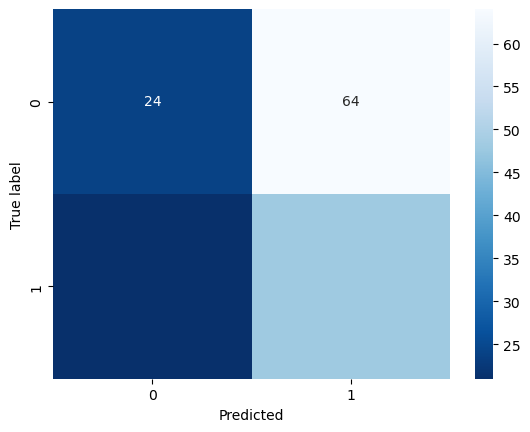

In [103]:
cm_0_3 = confusion_matrix(y_test_log, data['y_proba'].apply(lambda x: 'не вкусно' if x >= 0.3 else 'вкусно'))
sns.heatmap(cm_0_3, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
None

Как видим, количество ошибок FN сократилось более, чем в 2 раза.

Применим далее модель логистической регрессии к таблице `cow_buy`. Для этого сперва нормализуем и масштабируем данные:

In [104]:
cow_buy.head()

,breed,pasture_type,dad_breed,dad_name,fat,protein,energy_feed_unit_squared,raw_protein,sugar_protein_ratio_classified,age,milk_yield_predicted
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,233.361138,2019.947532,1,1,6631.071482
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,233.361138,2019.947532,1,1,5937.274786
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,233.361138,2019.947532,1,1,6181.858812
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,233.361138,2019.947532,1,1,6136.778261
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,233.361138,2019.947532,1,1,5974.390469


In [105]:
cow_buy_X = cow_buy[['breed', 'pasture_type', 'dad_breed', 'dad_name', 'fat', 'protein',
       'energy_feed_unit_squared', 'raw_protein',
       'sugar_protein_ratio_classified', 'age']]

In [106]:
cat_col_names_buy_2 = ["breed", "pasture_type", "dad_breed"]

cow_buy_ohe_2 = encoder.fit_transform(cow_buy[cat_col_names_buy_2])

encoder_col_names_buy_2 = encoder.get_feature_names_out()

cow_buy_ohe_2 = pd.DataFrame(cow_buy_ohe_2, columns=cat_col_names_buy_2).reset_index().drop(['index'], axis=1)

In [107]:
num_col_names_2 = ['fat','protein', 'energy_feed_unit_squared', 'raw_protein']

cow_buy_scaled_2 = scaler.fit_transform(cow_buy[num_col_names_2])

cow_buy_scaled_2 = pd.DataFrame(cow_buy_scaled_2, columns=num_col_names_2).reset_index().drop(['index'], axis=1)

In [108]:
cow_buy_concat_2 = pd.concat([cow_buy_ohe_2, cow_buy_scaled_2, df_cow_buy_dad_name_ohe], axis=1)
cow_buy_concat_2['sugar_protein_ratio_classified'] = sugar_protein_ratio_classifier(ferma_main.sugar_protein_ratio.mean()*1.05)
cow_buy_concat_2['age'] = 1
cow_buy_concat_2.head()

,breed,pasture_type,dad_breed,fat,protein,energy_feed_unit_squared,raw_protein,x0_Буйный,x0_Геркулес,x0_Соловчик,sugar_protein_ratio_classified,age
0,0.0,1.0,0.0,0.020225,0.645020,0.0,4.547474e-13,0.0,1.0,0.0,1,1
1,0.0,0.0,1.0,-0.303380,1.141190,0.0,4.547474e-13,1.0,0.0,0.0,1,1
2,1.0,0.0,1.0,0.101127,0.446553,0.0,4.547474e-13,0.0,0.0,0.0,1,1
3,1.0,1.0,0.0,-1.436000,-0.843488,0.0,4.547474e-13,1.0,0.0,0.0,1,1
4,1.0,0.0,0.0,0.505634,0.446553,0.0,4.547474e-13,1.0,0.0,0.0,1,1


In [109]:
cow_buy_concat_2 = cow_buy_concat_2[['breed', 'pasture_type', 'dad_breed', 'age', 'energy_feed_unit_squared',
       'raw_protein', 'fat', 'protein', 'x0_Буйный', 'x0_Геркулес', 'x0_Соловчик',
       'sugar_protein_ratio_classified']]

Предскажем значения категориального признака `milk_taste`

In [110]:
predictions_log_2 = model_log.predict(cow_buy_concat_2)
predictions_log_2

array(['вкусно', 'вкусно', 'вкусно', 'вкусно', 'вкусно', 'не вкусно',
       'вкусно', 'вкусно', 'вкусно', 'вкусно', 'не вкусно', 'вкусно',
       'не вкусно', 'вкусно', 'вкусно', 'вкусно', 'вкусно', 'не вкусно',
       'вкусно', 'вкусно'], dtype=object)

Добавим в таблицу `cow_buy` столбец `y_proba` и используем сниженное пороговое значения (0.3) для отбора коров с вкусным молоком:

In [111]:
cow_buy['y_proba'] = model_log.predict_proba(cow_buy_concat_2)[:,1]
cow_buy['milk_taste_predicted_0_5'] = predictions_log_2
cow_buy['milk_taste_predicted_y_proba_0_3'] = cow_buy['y_proba'].apply(lambda x: 'не вкусно' if x >= 0.30 else 'вкусно')
cow_buy.head()

,breed,pasture_type,dad_breed,dad_name,fat,protein,energy_feed_unit_squared,raw_protein,sugar_protein_ratio_classified,age,milk_yield_predicted,y_proba,milk_taste_predicted_0_5,milk_taste_predicted_y_proba_0_3
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,233.361138,2019.947532,1,1,6631.071482,0.339575,вкусно,не вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,233.361138,2019.947532,1,1,5937.274786,0.414099,вкусно,не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,233.361138,2019.947532,1,1,6181.858812,0.405162,вкусно,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,233.361138,2019.947532,1,1,6136.778261,0.394425,вкусно,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,233.361138,2019.947532,1,1,5974.390469,0.473066,вкусно,не вкусно


Отберем коров, для которых спрогнозирован удой более 6000 килограммов в год и вкусное молоко:

In [112]:
cows_to_buy = cow_buy.query('(milk_yield_predicted > 6000) & (milk_taste_predicted_y_proba_0_3 == "вкусно")')
cows_to_buy

,breed,pasture_type,dad_breed,dad_name,fat,protein,energy_feed_unit_squared,raw_protein,sugar_protein_ratio_classified,age,milk_yield_predicted,y_proba,milk_taste_predicted_0_5,milk_taste_predicted_y_proba_0_3
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,233.361138,2019.947532,1,1,6136.778261,0.292183,вкусно,вкусно
13,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,233.361138,2019.947532,1,1,6292.211287,0.275875,вкусно,вкусно


- Как видим, таких коров получилось `2 штуки`. На основании проделанного анализа рекомендуется выбрать именно их
- Учитывая `допущения` по таким показателям, как `возраст`, `ЭКЕ`, `сырой протеин`, `СПО`, при непосредсвтенном выбори стоит учитывать их `реальные` значения

<div class="alert"; style="border-left: 7px solid pink">

**Мини-вывод**
- На основании данных из таблицы `farm_main` была создана и обучена модель логистической регрессии. Целевой признак -  `milk_taste`.
- При покупке коров критичнее всего `ложно-отрицательная ошибка`(FN), поскольку в таком лучае фермер купит корову, которая, как он предполагает будет давать вкусное молоко, а она даст невкусное. Следовательно, необходимо `повысить` метрику `recall`
- При критической вероятности в `0.14` ошибка `FN` будет сведена к `0`.
- Исходя из анализа модели, следует `слегка снизить порог`, чтобы уменьшить веротяность ошибки `FN`.
- Модель логистической регрессии была применена к данным продавца (`cow_buy`). 
- В результате работы модели было определено `2 коровы` с необходимыми для фермера прогнозными значениями целевого признака.
- Учитывая допущения по таким показателям, как 'возраст', 'ЭКЕ', 'сырой протеин', 'СПО', при непосредсвтенном выборе коров фермеру стоит учитывать `реальные значения` по данными признакам.
</div>

## Вывод <a id='8'></a>

В рамках данного исследования анализировались данные по коровам `молочного хозяйства «Вольный луг»` **с целью** предсказать возможный удой и вероятность дать вкусное молоко у коровы.

Для достижения цели были созданы две прогнозные модели МО, предсказывающие с определенной долей точности показатели "Удой" и "Вкус молока".

Перед работой над созданием моделей данные были **предобработаны**:
- Данные в таблице `ferma_main` и `cow_buy` приведены к корректному типу;
- В таблице `ferma_main` и `cow_buy`  удалены дубликаты;
- Названия всех столбцов приведены к `змеиному регистру`.

Далее был произведен исследовательский аналих данных, в результате которого было выявлено:
- Признаки в большинстве своём не имеют нормальное распределение, многин данные фрагментарно распределены. Исключение составляет `milk_yield` - данный признак почти склонен к нормальному распределению;
- `~60%` коров имеют породу 'Вис Бик Айдиал', `~40%` - 'РефлешнСоверинг';
- `55.8%` коров паслись на холмистых лугах, `44.2%` - на равнинных;
- `50.6%` коров имеют отцов породы 'Айдиал', `49.4%` - 'Соверин';
- `~60%` - вкусное;
- Большинство коров (`82.5%`) имеют возраст более `2-х лет`;
- Отец коровы - один из пяти имен. Наиболее популярные - 'Барин' и 'Буйный';
- `~половина` коров 'ЭкоФермы' имеют породу 'Вис Бик Айдиал', остальные - 'РефлешнСоверинг'
- `~половина` коров 'ЭкоФермы' паслись на холмистых пастбищах, остальные - на холмистых;
- Среди коров для покупки преобладают те, у кого папа - породы 'Соверин' (`62.5%`)
- Среди коров для потенциальной попупки `1/3` - коровы, у которых папу зовут 'Геркулес', и почти половина тех, у кого папу зовут "Буйный". "Барин" - не такое популярное имя отца, как среди текущих коров;
- Удалена сточка, где в столбце "milk_yield" аномальное значение - `45616к` молока.
   
Далее был произведен **корреляционный** анализ данных, в результате которого было выявлено:
- Между целевым признаком и входными признакми есть `корреляции`;
- Среди входных признаков есть `несильная`, порой `нелинейная` корреляция. Однако так как в модель МО будут включаться только те признаки, которые подходят для обучения (ЭКЕ, Сырой протеин и СПО - не влияют на Удой), проблемы мультиколлинеарности можно избежать, грамотно подобрав параметры, доп. факторы вводить `не нужно`.
- Распределение значений либо `не нормальное`, либо `частино` нормальное
- Параметр содержание белка не коррелирует ни с каким из признаков

Далее была обучена и применена **модель линейной регрессии**:
- В процессе обучения модели линейной регрессии было создано `три варианта модели`: а) модель линейной регрессии на данных датасета farm_main б) модель линейной регрессии с преобразованными признаками, нелинейно связанных с целевым признаком, - СПО и ЭКЕ в) модель линейной регрессии с учётом нового признака - имени папы коровы
- Третий вариант модели показал себя `лучше` всего: `R²` = 0.814, `MSE` = 41645, `RMSE` = 204, `MAE` = 158.
- Третья модель была применена к данными продавца коров с учетом `допущений`, касающихся таких признаков, как ЭКЕ, Сырой протеин, СПО и возраст;
- `Предсказания` были внесены в таблицу;
- Выбранная модель была улучшена за счет того, что была `исключена нелинейность` признака 'СПО' и 'ЭКЕ'.

Далее была обучена и применена **модель логистической регрессии**:

- На основании данных из таблицы `farm_main` была создана и обучена модель логистической регрессии. Целевой признак -  `milk_taste`.
- При покупке коров критичнее всего `ложно-отрицательная ошибка`(FN), поскольку в таком лучае фермер купит корову, которая, как он предполагает будет давать вкусное молоко, а она даст невкусное. Следовательно, необходимо `повысить` метрику `recall`
- При критической вероятности в `0.14` ошибка `FN` будет сведена к `0`.
- Исходя из анализа модели, следует `слегка снизить порог`, чтобы уменьшить веротяность ошибки `FN`.
- Модель логистической регрессии была применена к данным продавца (`cow_buy`). 
- В результате работы модели было определено `2 коровы` с необходимыми для фермера прогнозными значениями целевого признака.
- Учитывая допущения по таким показателям, как 'возраст', 'ЭКЕ', 'сырой протеин', 'СПО', при непосредсвтенном выборе коров фермеру стоит учитывать `реальные значения` по данными признакам.